In [1]:
from cnmodel import populations
from cnmodel.util import sound, random_seed
from cnmodel.protocols import Protocol
from collections import OrderedDict
import os, sys, time
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from neuron import h
import multiprocessing as mp
from scipy.signal import savgol_filter
import yaml
import seaborn as sns

--No graphics will be displayed.
[2803295] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[2803295] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
[2803295] NumExpr defaulting to 16 threads.


In [2]:
sgc_pop = populations.SGC()
sgc_cfs = sgc_pop._get_cf_array(species='mouse')
b = (sgc_cfs[-1] - sgc_cfs[0]) / np.log(sgc_cfs[-1] / sgc_cfs[0])
a = sgc_cfs[0] - b * np.log(sgc_cfs[0])
sgc_cfs_log = a + b * np.log(sgc_cfs)

## Normal PA Network - 131 cfs 6kHz

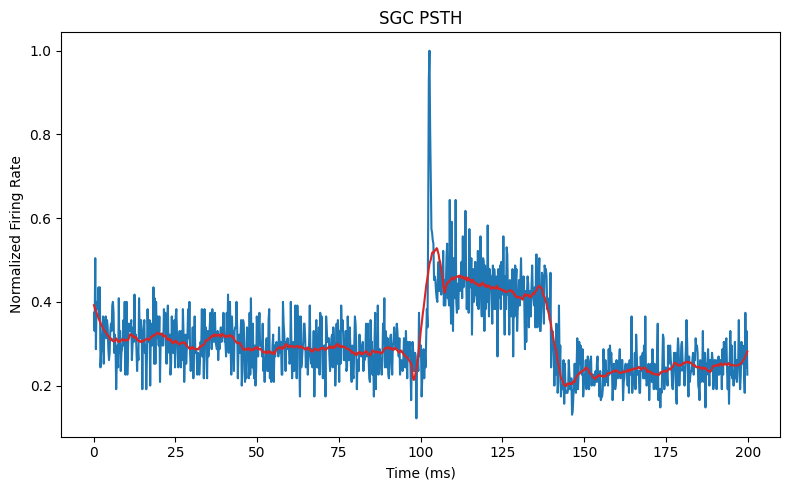

In [ ]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/131cfs_1dbs_6000if_1cpb_1nreps/results_df.pkl', 'rb'))

sgc_msfs = []
sgc_spkts = []

for stim, cells in results.values():
    temp = 6
    for cell_info, cell_data in cells.items():
        if isinstance(cell_info, str):
            continue
        cell_type = cell_info[0]
        cell_id = cell_info[1]
        if 'sgc' in cell_type:

            temp = 8
            spikes = cell_data[1]
            num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0])  if num_spikes > 1 else 1
            sgc_msfs.append(msf)
            sgc_spkts.extend(spikes)



sgc_spkts = np.array(sorted(np.array(sgc_spkts)))

bins = np.ceil((sgc_spkts.max() - sgc_spkts.min())/0.2)
y, binedges = np.histogram(sgc_spkts, bins=int(bins))  # returns the right edge of the bins
bincenters = 0.5*(binedges[1:]+binedges[:-1])  # better to use the center of the bins
binsize = bincenters[1] - bincenters[0]  # calculate the width of the bins
rates = y/binsize

fig, axs = plt.subplots(1,1,figsize=(8,5))

axs.plot(bincenters, rates/np.max(rates))
axs.plot(bincenters, savgol_filter(rates/np.max(rates), 50, 3), color='tab:red')
axs.set_title('SGC PSTH')
axs.set_xlabel('Time (ms)')
axs.set_ylabel('Normalized Firing Rate')
fig.tight_layout()

## Normal PA Network - 213 cfs, 22kHz if 40 dB

In [4]:
stimpar = {
    "dur": 0.2,
    "pip": 0.04,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 140],
}

input_freq = 22e3
input_level = 40

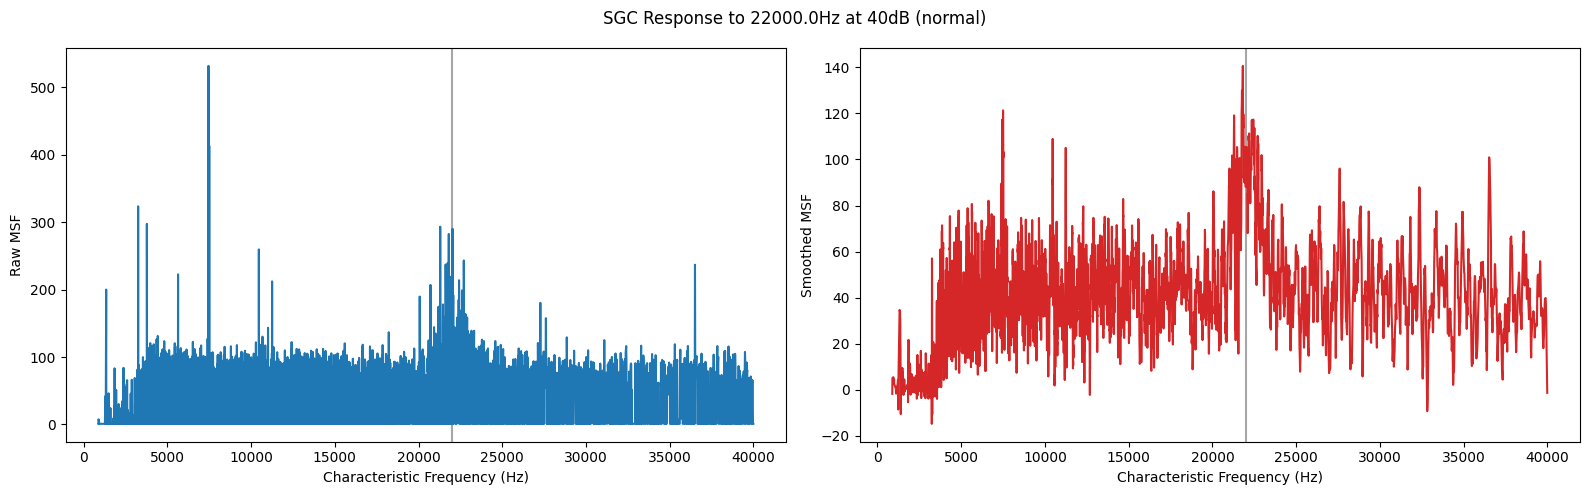

In [48]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))

sgc_msfs = []
n_spikes = []
sgc_ids = []

for stim, iterations in results.values():
    for cell, vec in iterations.items():
        temp = 6
        if 'sgc' in cell[0]:
            spikes = vec[1]
            num_spikes = len(spikes)  #((spikes >= stimpar['response'][0]) & (spikes < stimpar['response'][1])).sum()
            n_spikes.append(num_spikes)  #* (stimpar['response'][1] - stimpar['response'][0]))

            # resp_spkt = spikes[((spikes >= stimpar['response'][0]) & (spikes <= stimpar['response'][1]))]
            # num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
            sgc_msfs.append(msf)
            sgc_ids.append(cell[1])

n_spikes = np.array(n_spikes)
sgc_msfs = np.array(sgc_msfs)
nth_avg = 16
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
avg_msfs = ((sgc_msfs + np.roll(sgc_msfs,1))/nth_avg)[1::nth_avg]

fig, axs = plt.subplots(1,2,figsize=(16,5))
axs.ravel()

# axs[0].plot(sgc_cfs[sgc_ids[0::nth_avg]], avg_n_spikes, zorder=12)
# axs[0].plot(sgc_cfs[sgc_ids], n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(sgc_cfs[sgc_ids], savgol_filter(n_spikes, 15, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

# axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]], avg_msfs, color='k', zorder=12)
axs[0].plot(sgc_cfs[sgc_ids], sgc_msfs, color='tab:blue', zorder=12)
axs[0].set_ylabel('Raw MSF')

axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 15, 3), color='tab:red', zorder=13)
axs[1].set_ylabel('Smoothed MSF')
# axs[1].set_xlim(left=5)
# axs[1].set_ylim([-5, 100])

for ax in axs:

    # ax.axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
    ax.axvline(sgc_cfs[np.abs(np.array(sgc_cfs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(sgc_msfs)//(nticks-1)
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    ax.set_xlabel('Characteristic Frequency (Hz)')
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

fig.suptitle(f'SGC Response to {input_freq}Hz at {input_level}dB (normal)')
fig.tight_layout()

In [41]:
bins = np.ceil((n_spikes.max() - n_spikes.min())/0.1)
bins

np.float64(280.0)

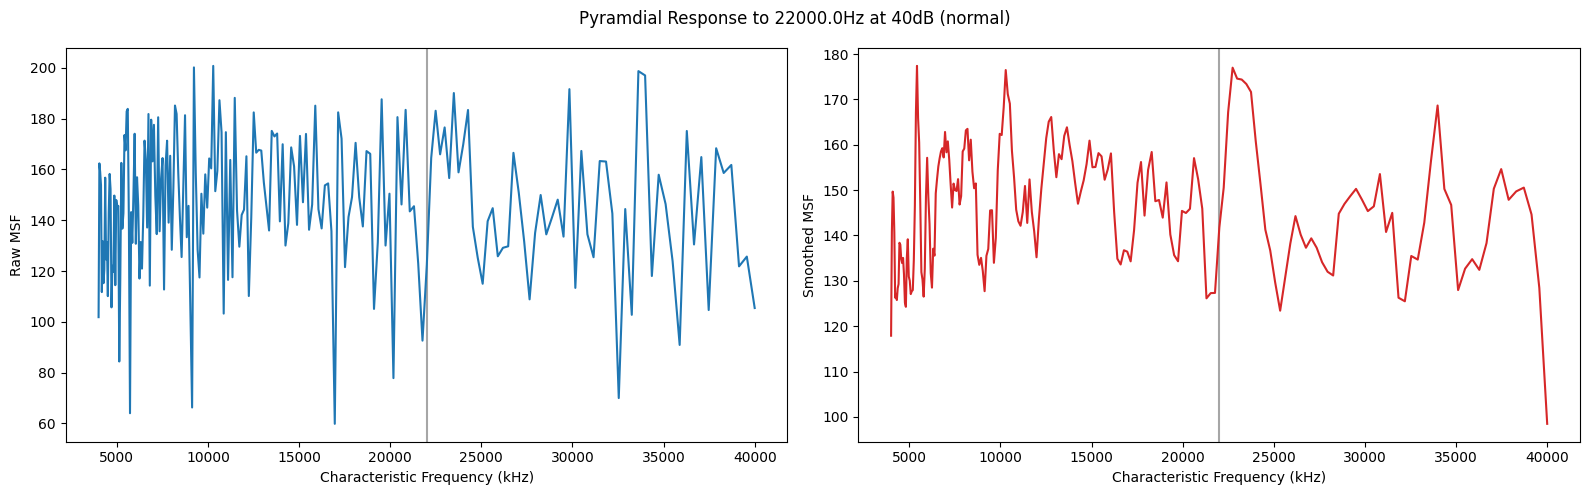

In [49]:
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
b = (freqs[-1] - freqs[0]) / np.log(freqs[-1] / freqs[0])
a = freqs[0] - b * np.log(freqs[0])
freqs_log = a + b * np.log(freqs)

pyr_msfs = []
n_spikes = []

for stim, iterations in results.values():
    for cell, vec in iterations.items():
        temp = 6
        if 'pyr' in cell[0]:
            spikes = vec[1]
            num_spikes = len(spikes)  #((spikes >= stimpar['response'][0]) & (spikes < stimpar['response'][1])).sum()
            n_spikes.append(num_spikes )  #* (stimpar['response'][1] - stimpar['response'][0]))

            # resp_spkt = spikes[((spikes >= stimpar['response'][0]) & (spikes <= stimpar['response'][1]))]
            # num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
            pyr_msfs.append(msf)

# loss_inds = freqs[np.where(np.array(freqs) > 30e3)]

fig, axs = plt.subplots(1,2,figsize=(16,5))
axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[0].plot(freqs, pyr_msfs, color='tab:blue', zorder=12)
axs[0].set_ylabel('Raw MSF')

axs[1].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:red', zorder=13)
axs[1].set_ylabel('Smoothed MSF')

for ax in axs:

    # ax.axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs)//(nticks-1)
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    ax.set_xlabel('Characteristic Frequency (kHz)')
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

fig.suptitle(f'Pyramdial Response to {input_freq}Hz at {input_level}dB (normal)')
fig.tight_layout()

np.float64(35883.11855734033)

## Hearing Loss PA - 22kHz if at 40dB

In [71]:
spont_spikes = 0
spont_time = 0


for stim, iterations in list(results.values()):
    for cell, vec in iterations.items():
        temp = 6
        if 'sgc' in cell[0]:
            spikes = np.array(vec[1])
            # if len(spikes) > 0:
            spont_spikes += ((spikes >= stimpar['baseline'][0]) * (spikes < stimpar['baseline'][1])).sum()
            spont_time += stimpar['baseline'][1] - stimpar['baseline'][0]

spont_rate = spont_spikes / spont_time


In [81]:
spont_spikes/len(sgc_ids)

np.float64(0.9574144486692016)

In [73]:
spont_rate*40

np.float64(0.7659315589353611)

In [24]:
stimpar = {
    "dur": 0.2,
    "pip": 0.04,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 140],
}

input_freq = 22e3
input_level = 40

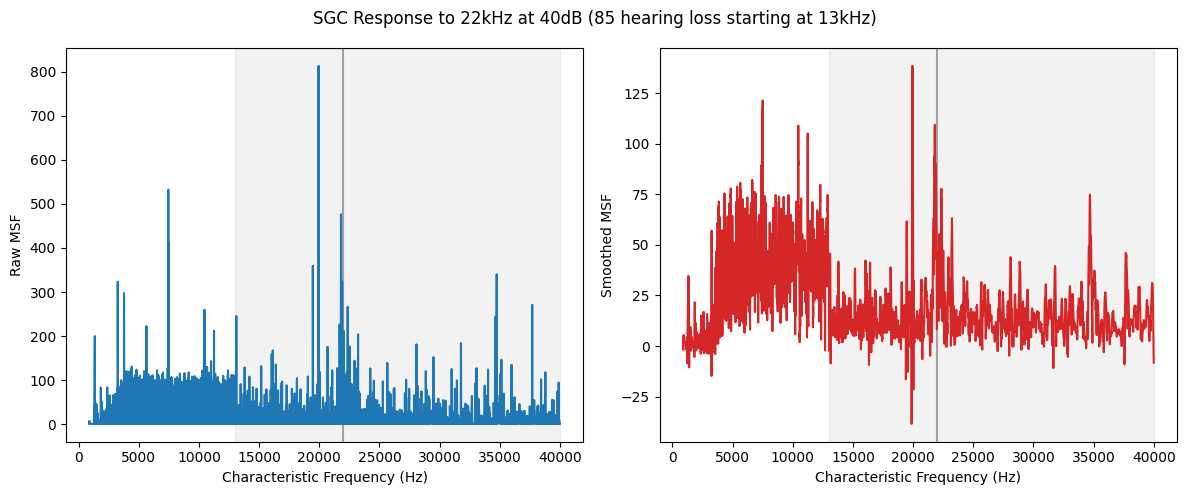

In [45]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_85/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))

sgc_msfs_loss = []
n_spikes = []
sgc_ids_loss = []

for stim, iterations in results.values():
    for cell, vec in iterations.items():
        temp = 6
        if 'sgc' in cell[0]:
            spikes = vec[1]
            num_spikes = len(spikes)  #((spikes >= stimpar['response'][0]) & (spikes < stimpar['response'][1])).sum()
            n_spikes.append(num_spikes)  #* (stimpar['response'][1] - stimpar['response'][0]))

            # resp_spkt = spikes[((spikes >= stimpar['response'][0]) & (spikes <= stimpar['response'][1]))]
            # num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
            sgc_msfs_loss.append(msf)
            sgc_ids_loss.append(cell[1])

n_spikes = np.array(n_spikes)
sgc_msfs_loss = np.array(sgc_msfs_loss)
nth_avg = 16
# avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# avg_msfs = ((msfs + np.roll(msfs,1))/nth_avg)[1::nth_avg]

fig, axs = plt.subplots(1,2,figsize=(12,5))
axs.ravel()

# axs[0].plot(sgc_cfs[sgc_ids], n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(sgc_cfs[sgc_ids], savgol_filter(n_spikes, 15, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

# axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]], avg_msfs, color='k', zorder=12)
axs[0].plot(sgc_cfs[sgc_ids], sgc_msfs_loss, color='tab:blue', zorder=12)
axs[0].set_ylabel('Raw MSF')

axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 15, 3), color='tab:red', zorder=13)
axs[1].set_ylabel('Smoothed MSF')
# axs[1].set_xlim(left=5)
# axs[1].set_ylim([-5, 100])

loss_inds = sgc_cfs[np.where(sgc_cfs > 13e3)]

for ax in axs:

    ax.axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
    ax.axvline(sgc_cfs[np.abs(np.array(sgc_cfs) - 22e3).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(msfs)//(nticks-1)
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    ax.set_xlabel('Characteristic Frequency (Hz)')
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

fig.suptitle('SGC Response to 22kHz at 40dB (85 hearing loss starting at 13kHz)')
fig.tight_layout()

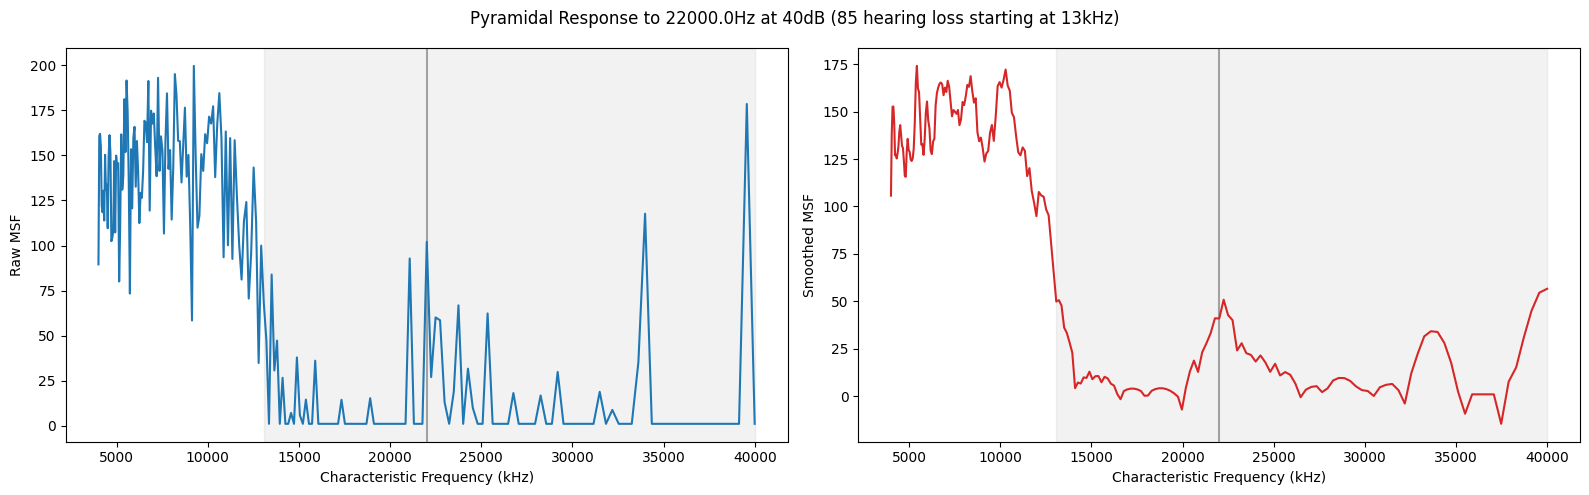

In [47]:
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_85/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
b = (freqs[-1] - freqs[0]) / np.log(freqs[-1] / freqs[0])
a = freqs[0] - b * np.log(freqs[0])
freqs_log = a + b * np.log(freqs)

pyr_msfs_loss = []
n_spikes = []

for stim, iterations in results.values():
    for cell, vec in iterations.items():
        temp = 6
        if 'pyr' in cell[0]:
            spikes = vec[1]
            num_spikes = len(spikes)  #((spikes >= stimpar['response'][0]) & (spikes < stimpar['response'][1])).sum()
            n_spikes.append(num_spikes )  #* (stimpar['response'][1] - stimpar['response'][0]))

            # resp_spkt = spikes[((spikes >= stimpar['response'][0]) & (spikes <= stimpar['response'][1]))]
            # num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
            pyr_msfs_loss.append(msf)

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

fig, axs = plt.subplots(1,2,figsize=(16,5))
axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[0].plot(freqs, pyr_msfs_loss, color='tab:blue', zorder=12)
axs[0].set_ylabel('Raw MSF')
axs[1].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[1].set_ylabel('Smoothed MSF')

for ax in axs:

    ax.axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    ax.set_xlabel('Characteristic Frequency (kHz)')
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.tight_layout()

## Normal vs Loss - 22kHz at 40dB

In [6]:
stimpar = {
    "dur": 0.2,
    "pip": 0.04,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 140],
}

input_freq = 22e3
input_level = 40

In [31]:
def get_spontaneous_rate(cell_type, results):
    spont_spikes = []
    spont_times = []


    for stim, iterations in list(results.values()):
        for cell, vec in iterations.items():
            temp = 6
            if cell_type in cell[0]:
                spikes = np.array(vec[1])
                # if len(spikes) > 0:
                spont_spikes.append(((spikes >= stimpar['baseline'][0]) * (spikes < stimpar['baseline'][1])).sum())
                spont_times.append(stimpar['baseline'][1] - stimpar['baseline'][0])

    spont_rates = np.array(spont_spikes) / np.array(spont_times)
    return spont_rates


In [53]:
def get_cell_nspikes(cell_type, results, response):
    n_spikes = []

    for stim, iterations in results.values():
        for cell, vec in iterations.items():

            if cell_type in cell[0]:
                spikes = np.array(vec[1])
                num_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()
                n_spikes.append(num_spikes)
    
    return np.array(n_spikes)

In [3]:
def get_pyramidal_msfs(pyr_ids_per_band, results):
    freqs = list(pyr_ids_per_band.keys())
    b = (freqs[-1] - freqs[0]) / np.log(freqs[-1] / freqs[0])
    a = freqs[0] - b * np.log(freqs[0])
    freqs_log = a + b * np.log(freqs)

    pyr_msfs = []

    for stim, iterations in results.values():
        for cell, vec in iterations.items():
            temp = 6
            if 'pyr' in cell[0]:
                spikes = vec[1]
                num_spikes = len(spikes)
                num_isi = num_spikes - 1 if num_spikes > 0 else 0
                msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
                pyr_msfs.append(msf)

    pyr_msfs = np.array(pyr_msfs)

    return freqs, pyr_msfs


In [4]:
def get_sgc_msfs(results):
    sgc_msfs = []
    sgc_ids = []

    for stim, iterations in results.values():
        for cell, vec in iterations.items():
            temp = 6
            if 'sgc' in cell[0]:
                spikes = vec[1]
                num_spikes = len(spikes)
                num_isi = num_spikes - 1 if num_spikes > 0 else 0
                msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
                sgc_msfs.append(msf)
                sgc_ids.append(cell[1])

    sgc_msfs = np.array(sgc_msfs)
    
    return sgc_ids, sgc_msfs

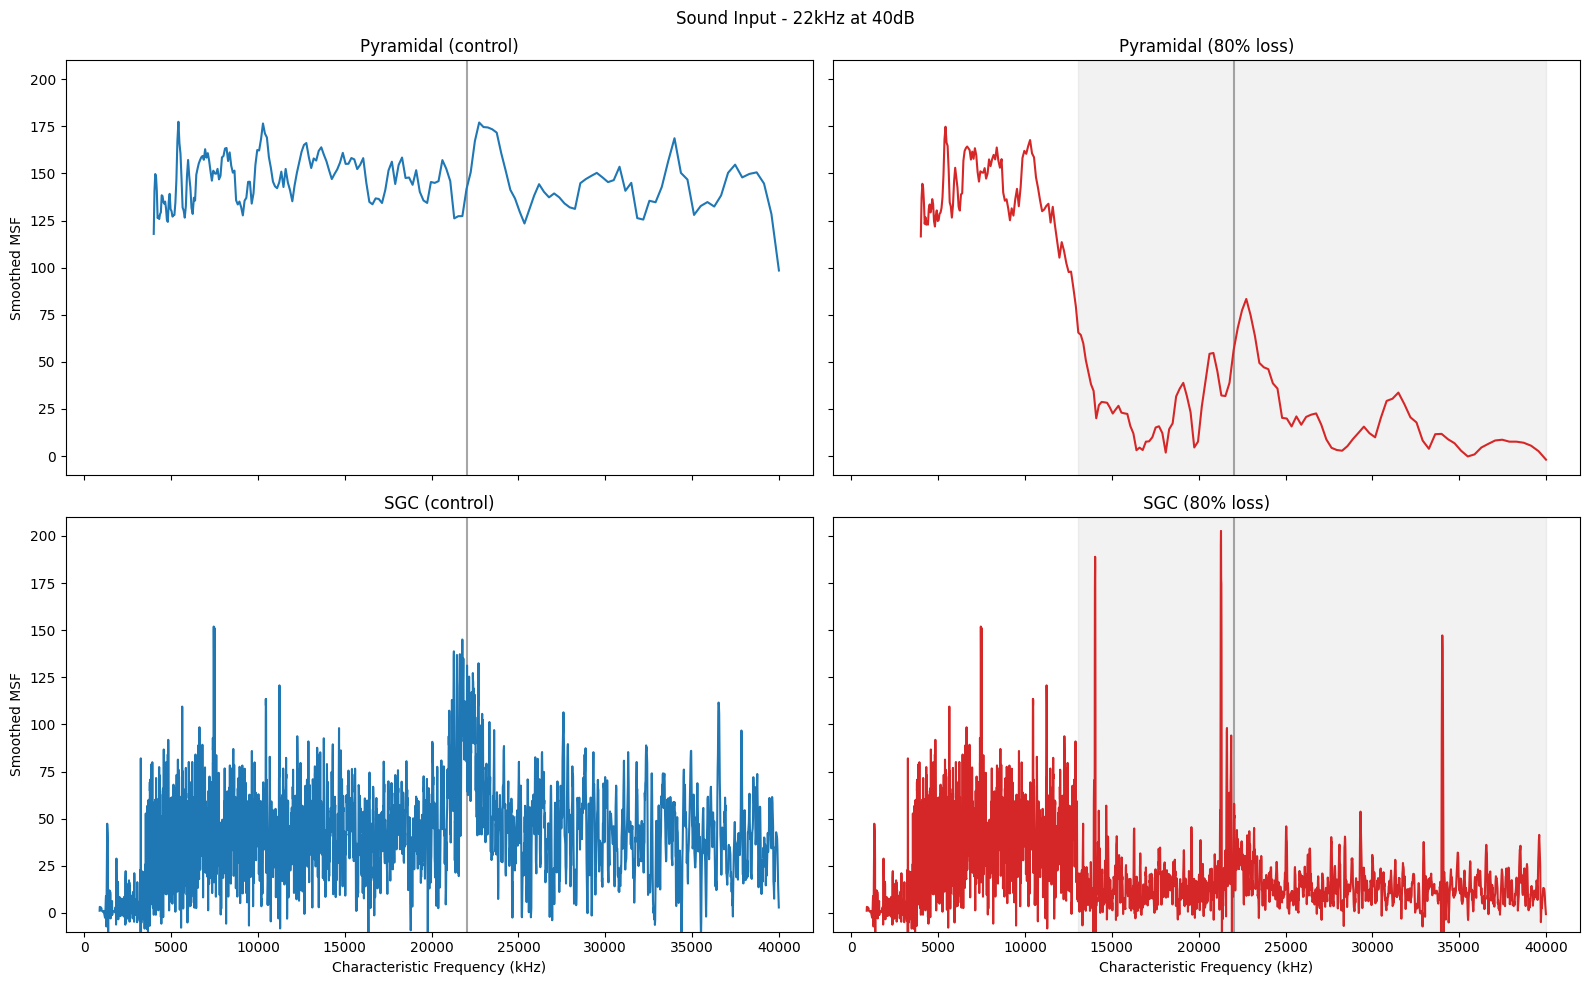

In [45]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs, pyr_msfs = get_pyramidal_msfs(pyr_ids_per_band, results)
sgc_ids, sgc_msfs = get_sgc_msfs(results)

loss_frac = 80
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss, pyr_msfs_loss = get_pyramidal_msfs(pyr_ids_per_band, results_loss)
sgc_ids_loss, sgc_msfs_loss = get_sgc_msfs(results_loss)

fig, axs = plt.subplots(2,2,figsize=(16,10), sharex=True, sharey=True)
# axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[1,0].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 10, 3), color='tab:blue', zorder=13)
axs[1,0].set_title('SGC (control)')
axs[1,1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[1,1].set_title(f"SGC ({loss_frac}% loss)")

axs[0,0].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:blue', zorder=13)
axs[0,0].set_title('Pyramidal (control)')
axs[0,1].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[0,1].set_title(f'Pyramidal ({loss_frac}% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs.ravel():

    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0,0].set_ylabel('Smoothed MSF')
axs[1,0].set_ylabel('Smoothed MSF')

axs[1,0].set_xlabel('Characteristic Frequency (kHz)')
axs[1,1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

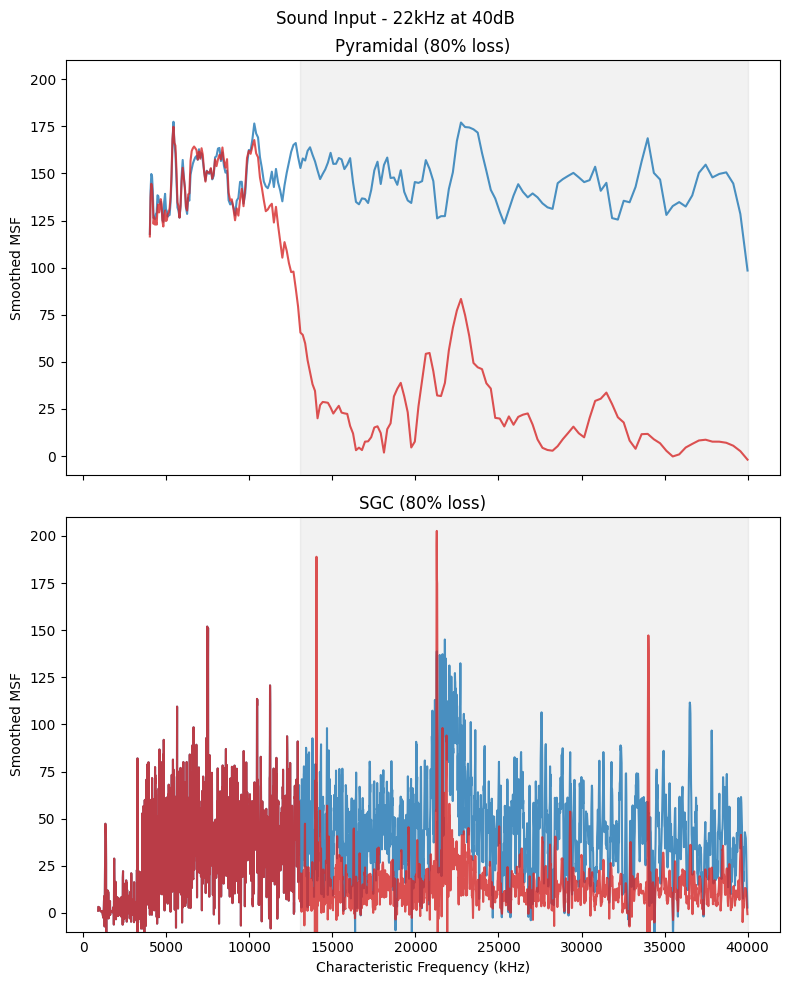

In [51]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs, pyr_msfs = get_pyramidal_msfs(pyr_ids_per_band, results)
sgc_ids, sgc_msfs = get_sgc_msfs(results)

loss_frac = 80
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss, pyr_msfs_loss = get_pyramidal_msfs(pyr_ids_per_band, results_loss)
sgc_ids_loss, sgc_msfs_loss = get_sgc_msfs(results_loss)

fig, axs = plt.subplots(2,1,figsize=(8,10), sharex=True, sharey=True)
axs = axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 10, 3), color='tab:blue', zorder=13, alpha=0.8)
axs[1].set_title('SGC (control)')
axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 10, 3), color='tab:red', zorder=13, alpha=0.8)
axs[1].set_title(f"SGC ({loss_frac}% loss)")

axs[0].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:blue', zorder=13, alpha=0.8)
axs[0].set_title('Pyramidal (control)')
axs[0].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13, alpha=0.8)
axs[0].set_title(f'Pyramidal ({loss_frac}% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Smoothed MSF')
axs[1].set_ylabel('Smoothed MSF')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

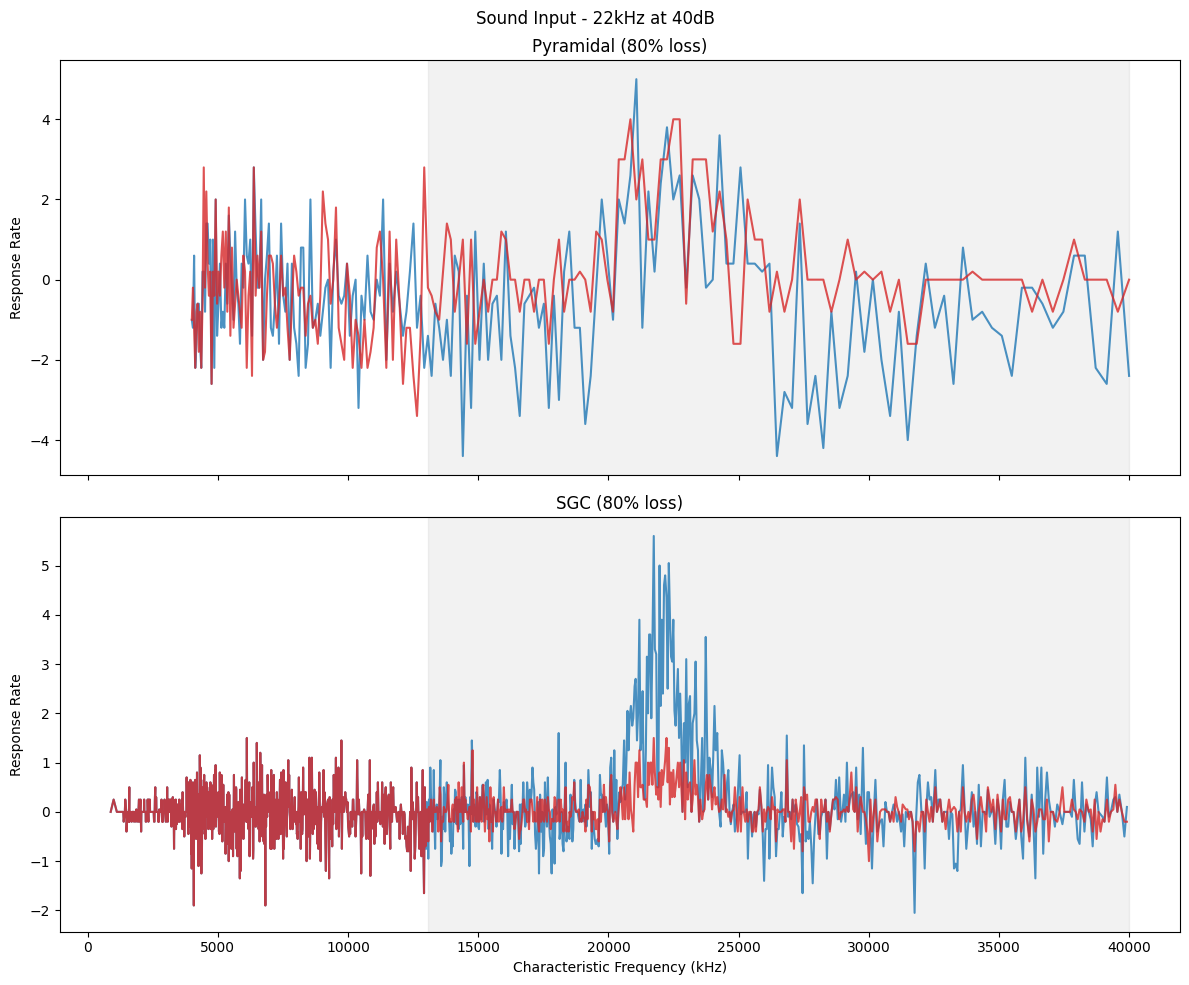

In [ ]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_spont_rates = get_spontaneous_rate('pyramidal', results)
sgc_spont_rates = get_spontaneous_rate('sgc', results)
pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'])
sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

loss_frac = 80
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss)
pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'])
sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

fig, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)  #, sharey=True)
axs = axs.ravel()


# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')
# - sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
nth_avg = 4
n_spikes = sgc_resp_spikes- sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]],  avg_n_spikes, color='tab:blue', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_resp_spikes- sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0]), win_length, 3) , color='tab:blue', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids], sgc_resp_spikes- sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0]) , color='tab:blue', zorder=13, alpha=0.8)
axs[1].set_title('SGC (control)')

n_spikes = sgc_resp_spikes_loss- sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]],  avg_n_spikes, color='tab:red', zorder=13, alpha=0.8)
# - sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
# axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_resp_spikes_loss- sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]), win_length, 3) , color='tab:red', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids_loss], sgc_resp_spikes_loss- sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]) , color='tab:red', zorder=13, alpha=0.8)
axs[1].set_title(f"SGC ({loss_frac}% loss)")

win_length = 40
polyorder = 3
# nth_avg = 1
# n_spikes = pyr_resp_spikes- pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
# avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[0].plot(freqs[0::nth_avg], avg_n_spikes, color='tab:blue', zorder=13, alpha=0.8)
# - pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes- pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0]), win_length, polyorder) , color='tab:blue', zorder=13, alpha=0.8)
axs[0].plot(freqs, pyr_resp_spikes- pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0]) , color='tab:blue', zorder=13, alpha=0.8)
axs[0].set_title('Pyramidal (control)')

# n_spikes = pyr_resp_spikes_loss- pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
# avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[0].plot(freqs[0::nth_avg],  avg_n_spikes, color='tab:red', zorder=13, alpha=0.8)
# - pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes_loss- pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]), win_length, polyorder) , color='tab:red', zorder=13, alpha=0.8)
axs[0].plot(freqs, pyr_resp_spikes_loss- pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]) , color='tab:red', zorder=13, alpha=0.8)
axs[0].set_title(f'Pyramidal ({loss_frac}% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    # ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate')
axs[1].set_ylabel('Response Rate')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

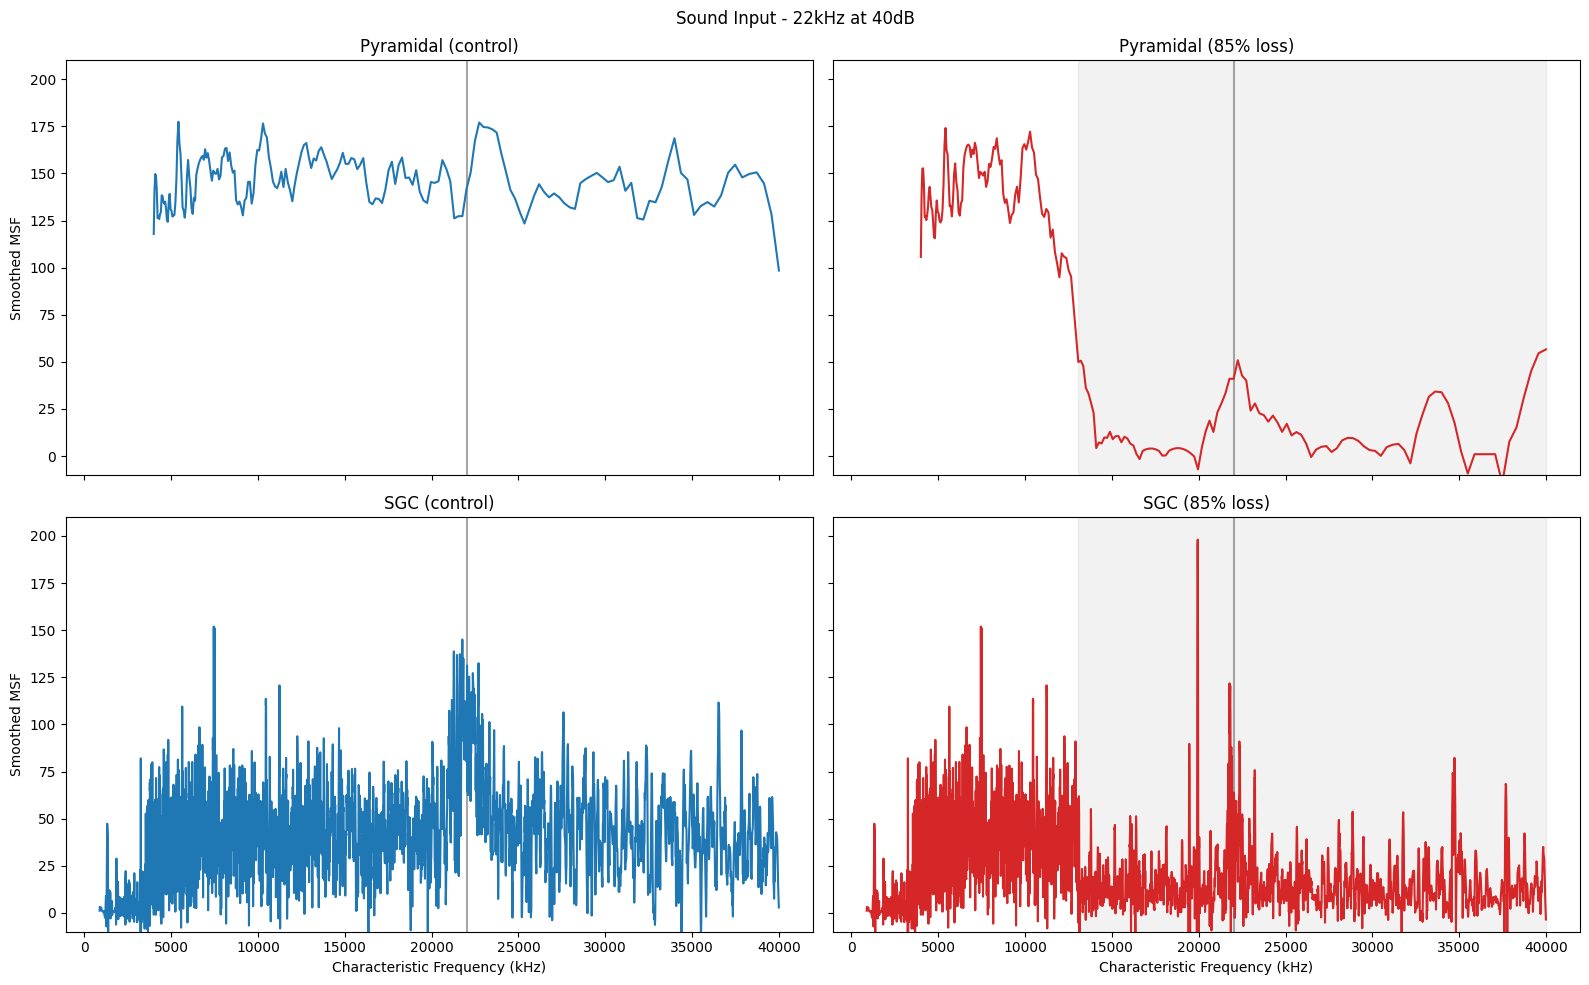

In [66]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs, pyr_msfs = get_pyramidal_msfs(pyr_ids_per_band, results)
sgc_ids, sgc_msfs = get_sgc_msfs(results)

results_loss = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_85/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_85/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss, pyr_msfs_loss = get_pyramidal_msfs(pyr_ids_per_band, results_loss)
sgc_ids_loss, sgc_msfs_loss = get_sgc_msfs(results_loss)

fig, axs = plt.subplots(2,2,figsize=(16,10), sharex=True, sharey=True)
# axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[1,0].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 10, 3), color='tab:blue', zorder=13)
axs[1,0].set_title('SGC (control)')
axs[1,1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[1,1].set_title("SGC (85% loss)")

axs[0,0].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:blue', zorder=13)
axs[0,0].set_title('Pyramidal (control)')
axs[0,1].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[0,1].set_title('Pyramidal (85% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs.ravel():

    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0,0].set_ylabel('Smoothed MSF')
axs[1,0].set_ylabel('Smoothed MSF')

axs[1,0].set_xlabel('Characteristic Frequency (kHz)')
axs[1,1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

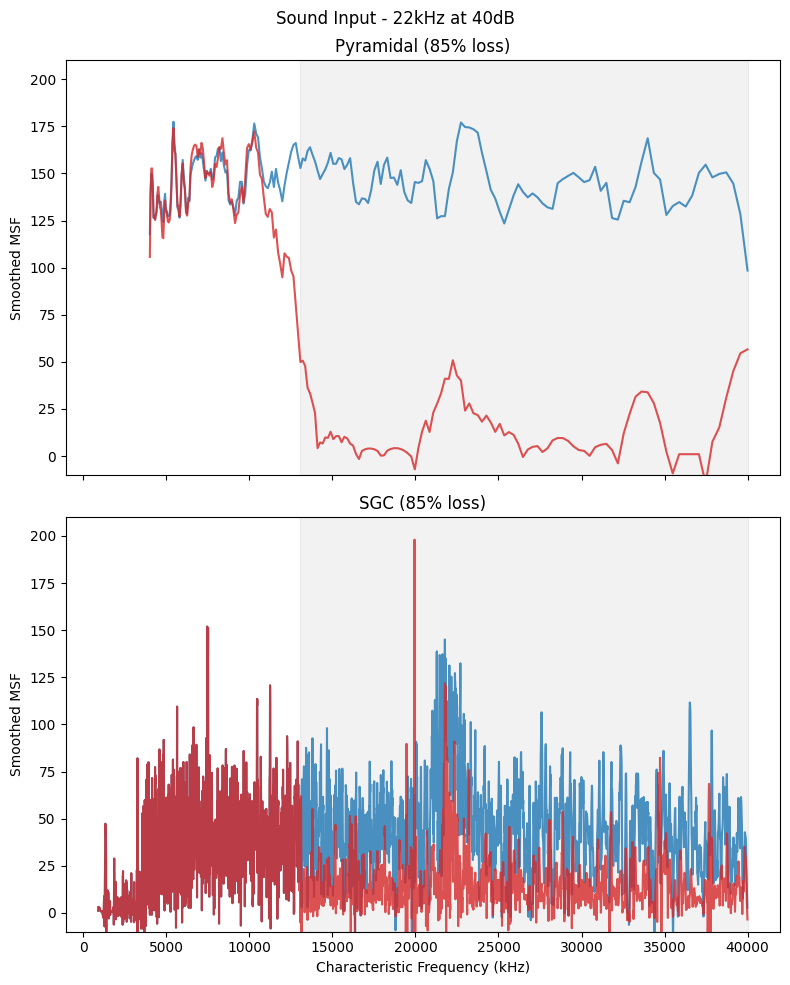

In [52]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs, pyr_msfs = get_pyramidal_msfs(pyr_ids_per_band, results)
sgc_ids, sgc_msfs = get_sgc_msfs(results)

loss_frac = 85
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss, pyr_msfs_loss = get_pyramidal_msfs(pyr_ids_per_band, results_loss)
sgc_ids_loss, sgc_msfs_loss = get_sgc_msfs(results_loss)

fig, axs = plt.subplots(2,1,figsize=(8,10), sharex=True, sharey=True)
axs = axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 10, 3), color='tab:blue', zorder=13, alpha=0.8)
axs[1].set_title('SGC (control)')
axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 10, 3), color='tab:red', zorder=13, alpha=0.8)
axs[1].set_title(f"SGC ({loss_frac}% loss)")

axs[0].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:blue', zorder=13, alpha=0.8)
axs[0].set_title('Pyramidal (control)')
axs[0].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13, alpha=0.8)
axs[0].set_title(f'Pyramidal ({loss_frac}% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Smoothed MSF')
axs[1].set_ylabel('Smoothed MSF')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

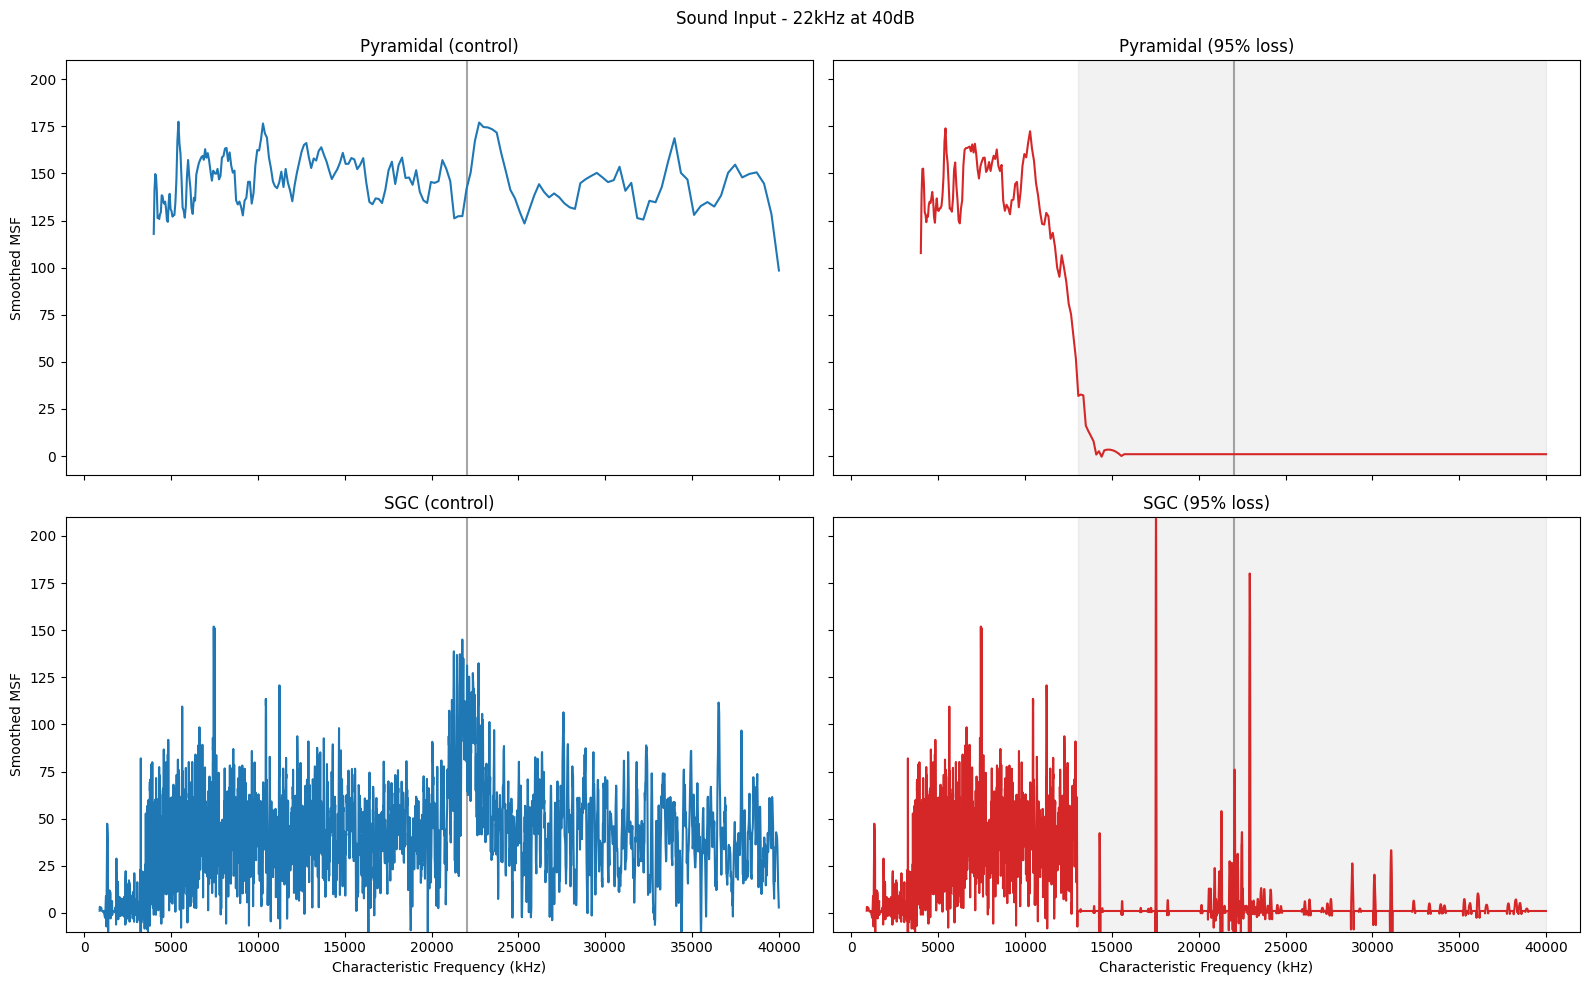

In [65]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs, pyr_msfs = get_pyramidal_msfs(pyr_ids_per_band, results)
sgc_ids, sgc_msfs = get_sgc_msfs(results)

results_loss = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_95/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_95/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss, pyr_msfs_loss = get_pyramidal_msfs(pyr_ids_per_band, results_loss)
sgc_ids_loss, sgc_msfs_loss = get_sgc_msfs(results_loss)

fig, axs = plt.subplots(2,2,figsize=(16,10), sharex=True, sharey=True)
# axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[1,0].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 10, 3), color='tab:blue', zorder=13)
axs[1,0].set_title('SGC (control)')
axs[1,1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[1,1].set_title("SGC (95% loss)")

axs[0,0].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:blue', zorder=13)
axs[0,0].set_title('Pyramidal (control)')
axs[0,1].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[0,1].set_title('Pyramidal (95% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs.ravel():

    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0,0].set_ylabel('Smoothed MSF')
axs[1,0].set_ylabel('Smoothed MSF')

axs[1,0].set_xlabel('Characteristic Frequency (kHz)')
axs[1,1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

## Scratch

In [111]:
sgc_cfs[np.where(sgc_cfs > 13e3)]

array([13000.54320596, 13006.85263942, 13013.16513498, ...,
       39954.88508586, 39974.27602091, 39993.67636679], shape=(2317,))

In [95]:
sgc_cfs

array([  500.        ,   500.24266038,   500.48543852, ...,
       39954.88508586, 39974.27602091, 39993.67636679], shape=(9032,))

In [87]:
len(sgc_ids[0::2])

2630

array([0.5, 1. , 0.5, ..., 0.5, 1. , 0. ], shape=(2630,))

## Normal 1P - 16kHz cf 27kHz if 76 dB

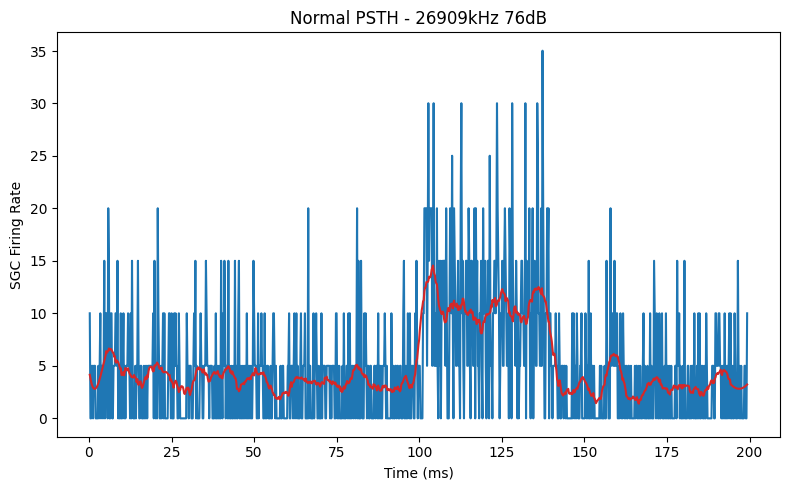

In [80]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

sgc_msfs = []
sgc_spkts = []

freq = 26909
level = 76
stim = f'f0: {freq}  dBspl: {level}'
cells = results[stim][1][0]

for cell_info, cell_data in cells.items():
    if isinstance(cell_info, str):
        continue
    cell_type = cell_info[0]
    cell_id = cell_info[1]
    if 'sgc' in cell_type:

        temp = 8
        spikes = cell_data[1]
        num_spikes = len(spikes)
        num_isi = num_spikes - 1 if num_spikes > 0 else 0
        msf = num_isi / (spikes[-1] - spikes[0])  if num_spikes > 1 else 1
        sgc_msfs.append(msf)
        sgc_spkts.extend(spikes)



sgc_spkts = np.array(sorted(np.array(sgc_spkts)))

bins = np.ceil((sgc_spkts.max() - sgc_spkts.min())/0.2)
y, binedges = np.histogram(sgc_spkts, bins=int(bins))  # returns the right edge of the bins
bincenters = 0.5*(binedges[1:]+binedges[:-1])  # better to use the center of the bins
binsize = bincenters[1] - bincenters[0]  # calculate the width of the bins
rates = y/binsize

fig, axs = plt.subplots(1,1,figsize=(8,5))

axs.plot(bincenters, rates)
axs.plot(bincenters, savgol_filter(rates, 50, 3), color='tab:red')
axs.set_title(f'Normal PSTH - {freq}kHz {level}dB')
axs.set_xlabel('Time (ms)')
axs.set_ylabel('SGC Firing Rate')
fig.tight_layout()

## Loss m1 1P - 16kHz cf 27k Hz if 76 dB

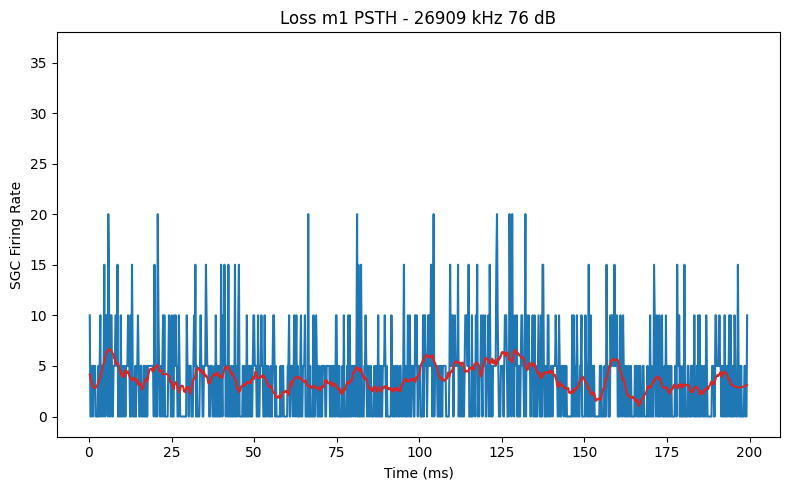

In [79]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m1/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

sgc_msfs = []
sgc_spkts = []

freq = 26909
level = 76
stim = f'f0: {freq}  dBspl: {level}'
cells = results[stim][1][0]

for cell_info, cell_data in cells.items():
    if isinstance(cell_info, str):
        continue
    cell_type = cell_info[0]
    cell_id = cell_info[1]
    if 'sgc' in cell_type:

        temp = 8
        spikes = cell_data[1]
        num_spikes = len(spikes)
        num_isi = num_spikes - 1 if num_spikes > 0 else 0
        msf = num_isi / (spikes[-1] - spikes[0])  if num_spikes > 1 else 1
        sgc_msfs.append(msf)
        sgc_spkts.extend(spikes)



sgc_spkts = np.array(sorted(np.array(sgc_spkts)))

bins = np.ceil((sgc_spkts.max() - sgc_spkts.min())/0.2)
y, binedges = np.histogram(sgc_spkts, bins=int(bins))  # returns the right edge of the bins
bincenters = 0.5*(binedges[1:]+binedges[:-1])  # better to use the center of the bins
binsize = bincenters[1] - bincenters[0]  # calculate the width of the bins
rates = y/binsize

fig, axs = plt.subplots(1,1,figsize=(8,5))

axs.plot(bincenters, rates)
axs.plot(bincenters, savgol_filter(rates, 50, 3), color='tab:red')
axs.set_title(f'Loss m1 PSTH - {freq} kHz {level} dB')
axs.set_xlabel('Time (ms)')
axs.set_ylabel('SGC Firing Rate')
axs.set_ylim([-2,38])
fig.tight_layout()

## Loss m2 - 16kHz cf 27kHz if

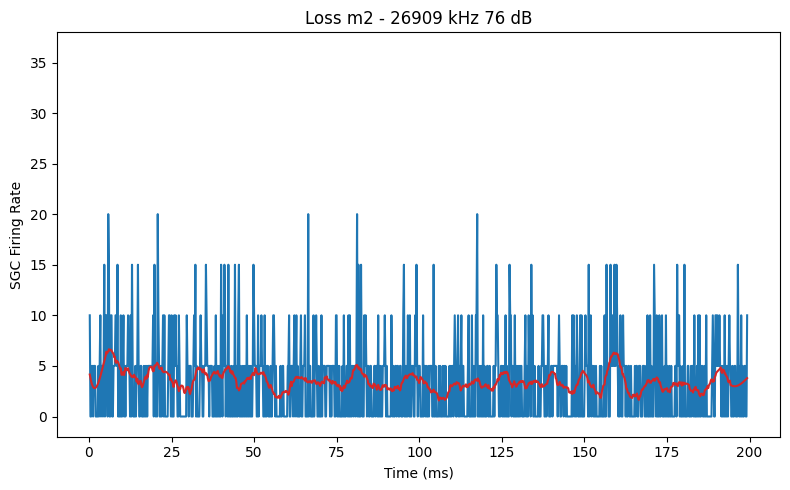

In [78]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m2/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

sgc_msfs = []
sgc_spkts = []

freq = 26909
level = 76
stim = f'f0: {freq}  dBspl: {level}'
cells = results[stim][1][0]

for cell_info, cell_data in cells.items():
    if isinstance(cell_info, str):
        continue
    cell_type = cell_info[0]
    cell_id = cell_info[1]
    if 'sgc' in cell_type:

        temp = 8
        spikes = cell_data[1]
        num_spikes = len(spikes)
        num_isi = num_spikes - 1 if num_spikes > 0 else 0
        msf = num_isi / (spikes[-1] - spikes[0])  if num_spikes > 1 else 1
        sgc_msfs.append(msf)
        sgc_spkts.extend(spikes)

sgc_spkts = np.array(sorted(np.array(sgc_spkts)))

bins = np.ceil((sgc_spkts.max() - sgc_spkts.min())/0.2)
y, binedges = np.histogram(sgc_spkts, bins=int(bins))  # returns the right edge of the bins
bincenters = 0.5*(binedges[1:]+binedges[:-1])  # better to use the center of the bins
binsize = bincenters[1] - bincenters[0]  # calculate the width of the bins
rates = y/binsize

fig, axs = plt.subplots(1,1,figsize=(8,5))

axs.plot(bincenters, rates)
axs.plot(bincenters, savgol_filter(rates, 50, 3), color='tab:red')
axs.set_title(f'Loss m2 - {freq} kHz {level} dB')
axs.set_xlabel('Time (ms)')
axs.set_ylabel('SGC Firing Rate')
axs.set_ylim([-2,38])
fig.tight_layout()